In [1]:
import sys
sys.path += ['..']

In [2]:
#import custom_need

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import mygene
import pickle
import numpy as np
import os

In [4]:
# wget https://toil.xenahubs.net/download/TARGET_phenotype.gz
# wget https://toil.xenahubs.net/download/target_RSEM_gene_tpm.gz

In [5]:
# Phenotype data
cf = pd.read_csv('../datastore/TARGET_phenotype.gz', sep='\t', index_col=0)

In [6]:
# Gene Expression data
df = pd.read_csv('../datastore/target_RSEM_gene_tpm.gz', sep='\t', index_col=0)

In [7]:
# Common sample ids
common = list(set(df.columns)&set(cf.index))

In [8]:
print 'Number of common samples between data and annotation: %s' % len(common)

Number of common samples between data and annotation: 734


In [9]:
# Dataset as samples x features/genes
df = df.T.loc[common,:]
cf = cf.loc[common,:]
ensembl_ids = [x.split('.')[0] for x in df.columns]

In [10]:
if not os.path.exists('../datastore/TARGET_gene_mapping.txt.gz') : 
    mg = mygene.MyGeneInfo()
    res = mg.getgenes(ensembl_ids, as_dataframe=True, 
                  fields='symbol,entrezgene,ensembl.type_of_gene,genomic_pos.chr')

    gene_mapping = pd.DataFrame( ensembl_ids, index=df.columns, columns=['query'])
    gene_mapping['ids'] = df.columns
    gene_mapping = gene_mapping.merge(res, on='query', how='left')

    l = []
    for v in list(gene_mapping.genomic_pos) : 
        try:
            v = v['chr']
            if v not in [str(x) for x in range(1,23)]+['MT', 'X', 'Y'] : 
                v = 'nan'
        except : 
            v = 'nan'
        l.append(v)

    
    gene_mapping = gene_mapping.loc[[x!='nan' for x in l],:]
    dups = gene_mapping.loc[gene_mapping.duplicated('ids'),'ids']
    print gene_mapping.loc[gene_mapping.ids.isin(dups),:]
    gene_mapping = gene_mapping.loc[~(gene_mapping.ids.isin(dups)),:]
    gene_mapping = gene_mapping.loc[pd.notnull(gene_mapping.symbol),:]
    gene_mapping = gene_mapping.loc[pd.notnull(gene_mapping.entrezgene),:]
    gene_mapping.to_csv('../datastore/TARGET_gene_mapping.txt.gz', sep='\t', compression='gzip')
else : 
    gene_mapping = pd.read_csv('../datastore/TARGET_gene_mapping.txt.gz', sep='\t', index_col=0)

In [11]:
# No more duplicates
gene_dups = list(set(gene_mapping.symbol[gene_mapping.duplicated('symbol')]))
gene_mapping.loc[(gene_mapping.symbol.isin(gene_dups)),:].sort_values('symbol')

,query,ids,_id,_score,ensembl,entrezgene,genomic_pos,notfound,symbol


In [12]:
gene_mapping.head(2)

,query,ids,_id,_score,ensembl,entrezgene,genomic_pos,notfound,symbol
0,ENSG00000242268,ENSG00000242268.2,100507661,19.223068,{u'type_of_gene': u'lincRNA'},100507661,{u'chr': u'3'},NaN,LINC02082
3,ENSG00000167578,ENSG00000167578.16,53916,17.492313,{u'type_of_gene': u'protein_coding'},53916,{u'chr': u'19'},NaN,RAB4B


In [13]:
dfo = df.loc[:,gene_mapping.ids]
dfo.columns = gene_mapping.symbol

In [14]:
dfo.iloc[0:2,0:10]

symbol,LINC02082,RAB4B,TIGAR,LINC01224,MIR4802,RNF44,DNAH3,RPL23A,ARL8B,DACH1
TARGET-30-PAPVRN-01,-9.9658,6.2447,1.2271,-1.7809,-9.9658,4.7203,-4.0350,8.9965,6.0483,-0.8599
TARGET-10-PASFXA-03,-9.9658,4.2088,0.8082,-9.9658,-9.9658,6.0153,-9.9658,11.4384,3.3003,-1.3548


In [15]:
dfo.to_csv('../datastore/TARGET_RSEM_gene_tpm.txt.gz', sep='\t',compression='gzip')
cf.to_csv('../datastore/TARGET_phenotype.txt.gz', sep='\t',compression='gzip')

In [16]:
#dfo = pd.read_csv('../datastore/TARGET_RSEM_gene_tpm.txt.gz', sep='\t', index_col=0)
#cf = pd.read_csv('../datastore/TARGET_phenotype.txt.gz', sep='\t', index_col=0)

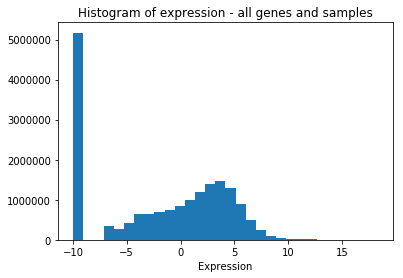

In [17]:
plt.hist(np.ravel(dfo.values), bins=30)
plt.title('Histogram of expression - all genes and samples')
plt.xlabel('Expression')
plt.show()

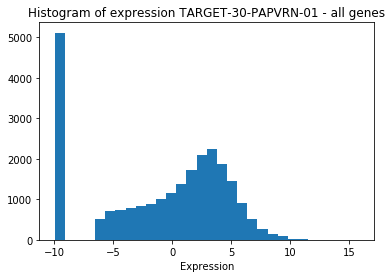

In [18]:
i = 0
plt.hist(dfo.iloc[i,:].values, bins=30)
plt.title('Histogram of expression %s - all genes' % dfo.index[i])
plt.xlabel('Expression')
plt.show()

TARGET-30-PAPVRN-01    5.621745
TARGET-10-PASFXA-03    6.015086
dtype: float64


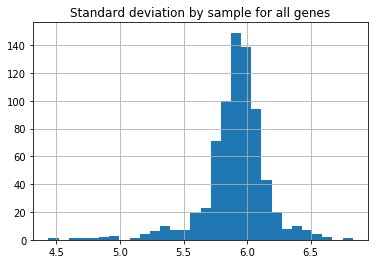

In [19]:
print dfo.std(1).head(2)
dfo.std(1).hist(bins=30)
plt.title('Standard deviation by sample for all genes')
plt.show()

symbol
LINC02082    3.088294
RAB4B        1.222264
dtype: float64


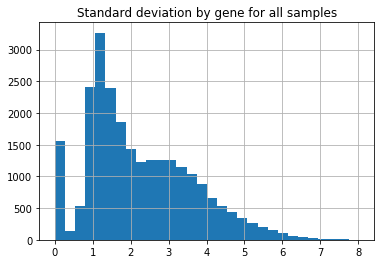

In [20]:
print dfo.std(0).head(2)
dfo.std(0).hist(bins=30)
plt.title('Standard deviation by gene for all samples')
plt.show()

TARGET-30-PAPVRN-01   -0.948142
TARGET-10-PASFXA-03   -3.094550
dtype: float64


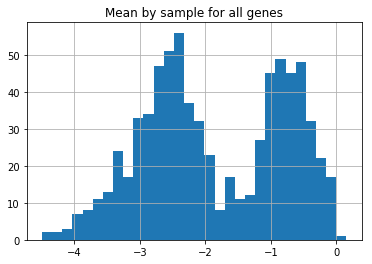

In [21]:
print dfo.mean(1).head(2)
dfo.mean(1).hist(bins=30)
plt.title('Mean by sample for all genes')
plt.show()

symbol
LINC02082   -8.098015
RAB4B        3.836123
dtype: float64


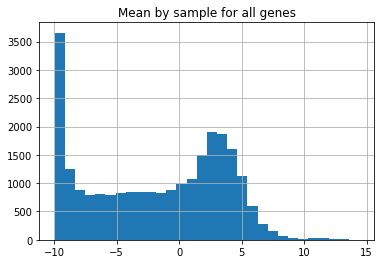

In [22]:
print dfo.mean(0).head(2)
dfo.mean(0).hist(bins=30)
plt.title('Mean by sample for all genes')
plt.show()